<a href="https://colab.research.google.com/github/AlkinD/Python-nlp/blob/master/auto_lyrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding,LSTM,Dense,Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np


In [0]:
!pip install kaggle

In [0]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [0]:
!kaggle datasets download -d PromptCloudHQ/taylor-swift-song-lyrics-from-all-the-albums

  0% 0.00/68.7k [00:00<?, ?B/s]
100% 68.7k/68.7k [00:00<00:00, 60.3MB/s]


In [0]:
!ls

kaggle.json  sample_data  taylor-swift-song-lyrics-from-all-the-albums.zip


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('taylor-swift-song-lyrics-from-all-the-albums.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()


In [0]:
import pandas as pd
#Load the dataset
dataset = pd.read_csv('/content/files/taylor_swift_lyrics.csv', encoding = "latin1")
dataset.head()



,artist,album,track_title,track_n,lyric,line,year
0,Taylor Swift,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006
1,Taylor Swift,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006
2,Taylor Swift,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006
3,Taylor Swift,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006
4,Taylor Swift,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006


In [0]:
def processFirstLine(lyrics, songID, songName, row):
    lyrics.append(row['lyric'] + '\n')
    songID.append( row['year']*100+ row['track_n'])
    songName.append(row['track_title'])
    return lyrics,songID,songName
# define empty lists for the lyrics , songID , songName 
lyrics = []
songID = []
songName = []
# songNumber indicates the song number in the dataset
songNumber = 1
# i indicates the song number
i = 0
isFirstLine = True
# Iterate through every lyrics line and join them together for each song independently 
for index,row in dataset.iterrows():
    if(songNumber == row['track_n']):
        if (isFirstLine):
            lyrics,songID,songName = processFirstLine(lyrics,songID,songName,row)
            isFirstLine = False
        else :
            #if we still in the same song , keep joining the lyrics lines    
            lyrics[i] +=  row['lyric'] + '\n'
    #When it's done joining a song's lyrics lines , go to the next song :    
    else :
        lyrics,songID,songName = processFirstLine(lyrics,songID,songName,row)
        songNumber = row['track_n']
        i+=1

In [0]:
lyrics_data = pd.DataFrame({'songID':songID, 'songName':songName, 'lyrics':lyrics })

In [0]:
print(lyrics_data)

In [0]:
# Save Lyrics in .txt file
with open('/content/files/lyricsTextnew.txt', 'w',encoding="utf-8") as filehandle:  
    for listitem in lyrics:
        filehandle.write('%s\n' % listitem)

In [0]:
!ls

files	     sample_data
kaggle.json  taylor-swift-song-lyrics-from-all-the-albums.zip


In [0]:
# Load the dataset and convert it to lowercase :
textFileName = '/content/files/lyricsTextnew.txt'
raw_text = open(textFileName, encoding = 'UTF-8').read()
raw_text = raw_text.lower()


In [0]:
tokenizer = Tokenizer()

data = open('/content/files/lyricsTextnew.txt').read()

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)


{'you': 1, 'i': 2, 'the': 3, 'and': 4, 'to': 5, 'me': 6, 'it': 7, 'a': 8, 'in': 9, 'my': 10, 'we': 11, 'your': 12, 'of': 13, 'all': 14, 'but': 15, 'that': 16, 'is': 17, 'know': 18, 'like': 19, "i'm": 20, 'on': 21, 'this': 22, 'oh': 23, 'be': 24, "don't": 25, 'so': 26, 'was': 27, "you're": 28, 'now': 29, "it's": 30, 'back': 31, 'when': 32, 'what': 33, 'just': 34, 'never': 35, 'are': 36, 'for': 37, 'with': 38, 'time': 39, 'up': 40, 'out': 41, 'love': 42, 'at': 43, 'do': 44, 'got': 45, 'if': 46, "'cause": 47, 'say': 48, 'one': 49, 'see': 50, 'baby': 51, 'want': 52, 'think': 53, 'go': 54, 'down': 55, 'ever': 56, 'they': 57, 'said': 58, 'been': 59, 'not': 60, 'he': 61, 'had': 62, "can't": 63, 'could': 64, "i'll": 65, 'look': 66, 'were': 67, 'no': 68, 'can': 69, 'how': 70, 'would': 71, 'come': 72, 'stay': 73, 'have': 74, 'take': 75, 'off': 76, 'made': 77, 'why': 78, 'wanna': 79, 'there': 80, 'yeah': 81, 'shake': 82, 'here': 83, 'night': 84, 'ey': 85, 'way': 86, 'tell': 87, 'about': 88, 'wish

In [0]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [0]:
print(tokenizer.word_index['in'])
print(tokenizer.word_index['the'])
print(tokenizer.word_index['dead'])
print(tokenizer.word_index['door'])
print(tokenizer.word_index['run'])
print(tokenizer.word_index['hate'])
print(tokenizer.word_index['cool'])
print(tokenizer.word_index['boy'])

In [0]:
print(xs[5])
print(ys[5])
print(xs[6])
print(ys[6])
print(tokenizer.word_index)

In [0]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(xs, ys, epochs=100, verbose=1)
#print model.summary()
print(model)
model.save('/content/files/auto_lyrics_model.h5')

Epoch 1/100
957/957 [==============================] - 9s 9ms/step - loss: 5.1883 - accuracy: 0.1523
Epoch 2/100
957/957 [==============================] - 9s 9ms/step - loss: 3.7386 - accuracy: 0.3110
Epoch 3/100
957/957 [==============================] - 9s 9ms/step - loss: 3.0241 - accuracy: 0.3925
Epoch 4/100
957/957 [==============================] - 9s 9ms/step - loss: 2.7514 - accuracy: 0.4332
Epoch 5/100
957/957 [==============================] - 9s 9ms/step - loss: 2.4383 - accuracy: 0.4745
Epoch 6/100
957/957 [==============================] - 9s 9ms/step - loss: 2.2075 - accuracy: 0.5007
Epoch 7/100
957/957 [==============================] - 9s 9ms/step - loss: 2.0556 - accuracy: 0.5244
Epoch 8/100
957/957 [==============================] - 9s 9ms/step - loss: 1.9515 - accuracy: 0.5475
Epoch 9/100
957/957 [==============================] - 9s 9ms/step - loss: 1.8877 - accuracy: 0.5566
Epoch 10/100
957/957 [==============================] - 9s 10ms/step - loss: 1.8200 - accur

In [0]:
model.save('/content/files/auto_lyrics_model.h5')
#from keras.models import load_model
#model = load_model('my_model.h5')

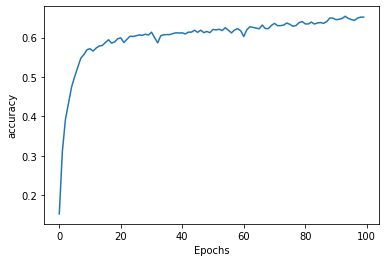

In [0]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

In [0]:
#Testing the model
#seed_text = "you are my destiny"
#seed_text = "I've got a bad feeling about this"
seed_text="he said the way my blue eyes shined"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word 
print(seed_text)

he said the way my blue eyes shined on the bleachers world tonight loved and left haunted planning myself hunters body whoa its sad movie gatsby for cause then discovered end game anymore by it garden clear into stars we'd end me near there enough coaster again last crowd dress cried too without me without fun trying oo whoa whoa ooh whoa ooh whoa ooh whoa leave beds mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm mmm
